# Modelos del lenguaje con RNNs

En esta parte, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar esta actividad con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

In [ ]:
import numpy as np
import re
import pandas as pd
import keras
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en `.txt` del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [ ]:
path = keras.utils.get_file(
    fname="don_quijote.txt",
    origin=" https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/textos/Don_Quijote_de_la_Mancha.txt"
)

### 1.1. Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas



Una vez descargado, se lee el contenido del fichero en una variable. Posteriormente, se convierte el texto a minúsculas para facilitar el aprendizaje del modelo. Esto permite evitar que el modelo tenga que distinguir entre caracteres en mayúscula y minúscula, reduciendo así la complejidad del vocabulario.

In [ ]:
# Abrir y leer el contenido
with open(path, 'r', encoding='utf-8') as f:
    ini_texto = f.read()

# Eliminar o mapear caracteres raros
texto = re.sub(r'[^a-záéíóúüñcç\s.,;!?"\'()-]', '', ini_texto.lower())

# Mostrar los primeros 500 caracteres (por ejemplo)
print(texto[:500])

capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. el resto della co


Para confirmar que el contenido se ha cargado correctamente, se imprime la longitud total del texto y los primeros 300 caracteres.

In [ ]:
print("Longitud del texto: {}".format(len(texto)))
print(texto[0:300])

Longitud del texto: 2067181
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



### 2.1. Obtención de los caracteres y mapas de caracteres

Antes de preparar los datos, es necesario identificar todos los caracteres distintos que aparecen en el texto. A cada uno de estos caracteres se le asigna un índice entero, formando un diccionario de mapeo en ambas direcciones:





In [ ]:
chars = sorted(list(set(texto)))

NUM_CHARS = len(chars)
char_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_char = dict((i, c) for i, c in enumerate(chars))

print(f"Número de caracteres únicos: {NUM_CHARS}")

Número de caracteres únicos: 44


### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de `SEQ_LENGTH` caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [ ]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

## TU CÓDIGO AQUÍ
for i in range(0, len(texto) - SEQ_LENGTH):
    sequences.append(texto[i:i + SEQ_LENGTH])
    next_chars.append(texto[i + SEQ_LENGTH])

Se indica la cantidad de pares secuencia/objetivo generados:

In [ ]:
print("Número total de secuencias generadas: {}".format(len(sequences)))

Número total de secuencias generadas: 2067151


Dado que el texto es extenso y genera una gran cantidad de secuencias, se opta por limitar el conjunto de entrenamiento a un máximo de 400.000 ejemplos para asegurar un entrenamiento manejable en términos de memoria.

In [ ]:
# Número máximo de secuencias a utilizar para reducir el tamaño del dataset
MAX_SEQUENCES = 400000

# Generar un array de índices aleatorios para barajar las secuencias
perm = np.random.permutation(len(sequences))

# Convertir las listas a arrays de NumPy para permitir el indexado con el array de permutación
sequences, next_chars = np.array(sequences), np.array(next_chars)

# Reordenar las secuencias y los caracteres objetivo utilizando la permutación aleatoria
sequences, next_chars = sequences[perm], next_chars[perm]

# Limitar el número de secuencias y caracteres objetivo al máximo definido y convertirlos de nuevo a listas
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])


print(len(sequences))

400000


### 2.3. Obtención de input X y output y para el modelo

Finalmente, con las secuencias de entrada y los caracteres objetivo ya preparados, se procede a convertirlos en arrays numéricos que puedan ser utilizados por el modelo. Para ello, se aplica codificación one-hot sobre cada carácter.

La codificación one-hot transforma cada carácter en un vector binario con un 1 en la posición correspondiente a su índice en el vocabulario, y ceros en las demás. Por ejemplo, si el vocabulario estuviera compuesto por los caracteres `['a', 'b', 'c', 'd']`, sus representaciones serían:

  - `'a'` → (1, 0, 0, 0)

  - `'b'` → (0, 1, 0, 0)

  - `'c'` → (0, 0, 1, 0)

  - `'d'` → (0, 0, 0, 1)

Se generan dos tensores:

- X: tensor de entrada con forma `(num_sequences, SEQ_LENGTH, NUM_CHARS)`

- y: tensor objetivo con forma `(num_sequences, NUM_CHARS)`


In [ ]:
# Obtener el número total de secuencias después de la limitación
NUM_SEQUENCES = len(sequences)

# Inicializar los arrays de entrada (X) y salida (y) con ceros.
# X tendrá la forma (número de secuencias, longitud de secuencia, número de caracteres únicos)
# y tendrá la forma (número de secuencias, número de caracteres únicos)
# Ambos usarán one-hot encoding.
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS), dtype=np.float32)
y = np.zeros((NUM_SEQUENCES, NUM_CHARS), dtype=np.float32)


# Iterar sobre cada secuencia en la lista de secuencias
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        # Convertir el carácter a su representación one-hot en el array X
        # La posición del 1 corresponde al índice del carácter en el vocabulario
        X[i, t, char_to_indices[char]] = 1

    # Convertir el carácter objetivo (el siguiente carácter) a su representación one-hot en el array y
    # La posición del 1 corresponde al índice del carácter objetivo en el vocabulario
    y[i, char_to_indices[next_chars[i]]] = 1

Una vez codificados los datos, se dividen en tres subconjuntos: entrenamiento, validación y prueba. La división se realiza de forma secuencial, asignando el 80% de las secuencias al entrenamiento, el 10% a validación y el 10% restante a prueba. Esta separación es fundamental para evaluar la capacidad de generalización del modelo.

In [ ]:
# Dividir los datos en entrenamiento, validación y prueba secuencialmente

# Obtener el número total de secuencias disponibles en X
NUM_SEQUENCES = X.shape[0]

# Calcular los tamaños de cada conjunto
# 80% para entrenamiento
train_size = int(0.8 * NUM_SEQUENCES)
# 10% para validación
val_size = int(0.1 * NUM_SEQUENCES)
# El 10% restante para prueba
test_size = NUM_SEQUENCES - train_size - val_size

# Realizar la división de los arrays X e y usando slicing
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}")
print(f"Shape de y_val: {y_val.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (320000, 30, 44)
Shape de y_train: (320000, 44)
Shape de X_val: (40000, 30, 44)
Shape de y_val: (40000, 44)
Shape de X_test: (40000, 30, 44)
Shape de y_test: (40000, 44)


#### Funciones necesarias

Esta función se encarga de entrenar un modelo de Keras utilizando los conjuntos de entrenamiento y validación. Posteriormente, evalúa su desempeño en el conjunto de prueba. Es útil para encapsular todo el proceso de entrenamiento y evaluación en una sola llamada.

In [ ]:
def train_and_test(model, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128, epochs=10, callbacks=None):
    """
    Entrena un modelo, opcionalmente evalúa en validación, y evalúa finalmente en prueba.

    Args:
        model: El modelo Keras a entrenar.
        X_train, y_train: Datos de entrenamiento.
        X_val, y_val: Datos de validación (pueden ser None).
        X_test, y_test: Datos de prueba.
        batch_size: Tamaño del lote para el entrenamiento.
        epochs: Número de épocas para el entrenamiento.
        callbacks: Lista de callbacks para el entrenamiento.

    Returns:
        model: El modelo entrenado.
        history: El objeto History del entrenamiento.
        report: El classification report en el conjunto de prueba (como diccionario).
    """
    print(f"Entrenando modelo: {model.name}")

    # Configurar datos de validación si están disponibles
    validation_data = None
    if X_val is not None and y_val is not None:
        validation_data = (X_val, y_val)

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1 # Mostrar progreso del entrenamiento
    )

    print("\nEvaluando modelo en el conjunto de prueba...")
    # Evaluar en el conjunto de prueba
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1) # Obtener el índice de la clase predicha

    # Convertir y_test de one-hot a índices de clase si está en one-hot
    # Asumimos que y_test puede venir en one-hot o como índices.
    # Si la suma de cada fila es 1, asumimos one-hot y convertimos.
    if len(y_test.shape) > 1 and np.all(np.sum(y_test, axis=1) == 1):
         y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test # Asumimos que ya son índices de clase

    # Identificar las clases presentes en los datos de prueba
    present_labels = np.unique(y_true)

    # Generar el classification report
    # Usamos target_names para todos los posibles caracteres
    target_names = [indices_to_char[i] for i in range(NUM_CHARS)]

    # Pasamos las etiquetas presentes explícitamente a classification_report
    report = classification_report(y_true, y_pred, labels=present_labels, target_names=target_names, output_dict=True, zero_division=0)


    print("Evaluación completa.")
    return model, history, report

Esta función permite comparar visualmente el desempeño de dos modelos distintos, típicamente un modelo base y uno modificado.

In [ ]:
def comparar_modelos(hist_base, hist_mod,
                 nombre_base='Modelo Base',
                 nombre_mod='Modelo Modificado'):
    """
    Compara el historial de entrenamiento de dos modelos (pérdida y precisión).

    Args:
        hist_base: El objeto History del entrenamiento del modelo base.
        hist_mod: El objeto History del entrenamiento del modelo modificado.
        nombre_base: Nombre para el modelo base en los gráficos.
        nombre_mod: Nombre para el modelo modificado en los gráficos.
    """
    # Extraer series de los historiales
    loss_b = hist_base.history['loss']
    acc_b  = hist_base.history['categorical_accuracy']
    loss_m = hist_mod.history['loss']
    acc_m  = hist_mod.history['categorical_accuracy']

    # Intentar obtener métricas de validación si existen
    val_loss_b = hist_base.history.get('val_loss')
    val_acc_b  = hist_base.history.get('val_categorical_accuracy')
    val_loss_m = hist_mod.history.get('val_loss')
    val_acc_m  = hist_mod.history.get('val_categorical_accuracy')


    # crear ejes x separados que comienzan en 1
    x_b = np.arange(1, len(loss_b) + 1)
    x_m = np.arange(1, len(loss_m) + 1)

    # límite común en x: de 1 al máximo número de épocas
    max_epochs = max(len(loss_b), len(loss_m))

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for ax in axs:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_xlim(1, max_epochs)

    # GRÁFICO DE PÉRDIDA
    axs[0].plot(x_b, loss_b,      label=f'{nombre_base} (Train)', zorder=3)
    if val_loss_b is not None:
        axs[0].plot(x_b, val_loss_b,  label=f'{nombre_base} (Val)',   zorder=3, linestyle='--')
    axs[0].plot(x_m, loss_m,      label=f'{nombre_mod} (Train)',  zorder=3)
    if val_loss_m is not None:
        axs[0].plot(x_m, val_loss_m,  label=f'{nombre_mod} (Val)',    zorder=3, linestyle='--')

    # Ajustar el límite superior del eje y de la pérdida
    all_losses = loss_b + loss_m
    if val_loss_b is not None:
        all_losses += val_loss_b
    if val_loss_m is not None:
        all_losses += val_loss_m
    y_max_loss = max(all_losses) if all_losses else 1.0
    axs[0].set_ylim(0, y_max_loss * 1.05)

    axs[0].set_title(f'Comparación de Pérdida — {nombre_base} vs {nombre_mod}')
    axs[0].set_xlabel('Época'); axs[0].set_ylabel('Pérdida')
    axs[0].legend(loc='upper right')

    # GRÁFICO DE RENDIMIENTO (Accuracy)
    axs[1].plot(x_b, acc_b,      label=f'{nombre_base} (Train)', zorder=3)
    if val_acc_b is not None:
        axs[1].plot(x_b, val_acc_b,  label=f'{nombre_base} (Val)',   zorder=3, linestyle='--')
    axs[1].plot(x_m, acc_m,      label=f'{nombre_mod} (Train)',  zorder=3)
    if val_acc_m is not None:
        axs[1].plot(x_m, val_acc_m,  label=f'{nombre_mod} (Val)',    zorder=3, linestyle='--')

    # Ajustar el límite superior del eje y de la precisión (hasta 1.0)
    all_accs = acc_b + acc_m
    if val_acc_b is not None:
        all_accs += val_acc_b
    if val_acc_m is not None:
        all_accs += val_acc_m
    y_max_acc = max(all_accs) if all_accs else 0.0
    axs[1].set_ylim(0, min(1.0, y_max_acc * 1.1))

    axs[1].set_title(f'Comparación de Rendimiento — {nombre_base} vs {nombre_mod}')
    axs[1].set_xlabel('Época'); axs[1].set_ylabel('Rendimiento')
    axs[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

Se trata de una función de utilidad que visualiza el comportamiento de pérdida y precisión de un modelo a lo largo de las épocas de entrenamiento.

In [ ]:
def plot_training_history(history, model_name="Modelo"):
    """
    Genera gráficos de pérdida y precisión del modelo durante el entrenamiento.

    Args:
        history: Objeto history devuelto por model.fit().
        model_name (str): Nombre del modelo para usar en los títulos de los gráficos.
    """
    plt.figure(figsize=(12, 5))

    # Crear un array para el eje X que comience en 1
    epochs = range(1, len(history.history['loss']) + 1)

    # Gráfico de Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Pérdida de Entrenamiento')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Pérdida durante el entrenamiento de {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.xlim(1, len(history.history['loss'])) # Establecer límite inferior del eje X a 1

    # Gráfico de Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['categorical_accuracy'], label='Rendimiento de Entrenamiento')
    if 'val_categorical_accuracy' in history.history:
        plt.plot(epochs, history.history['val_categorical_accuracy'], label='Rendimiento de Validación')
    plt.title(f'Rendimiento durante el entrenamiento de {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Rendimiento')
    plt.legend()
    plt.grid(True)
    plt.xlim(1, len(history.history['categorical_accuracy'])) # Establecer límite inferior del eje X a 1

    plt.tight_layout()
    plt.show()

Esta función genera texto automáticamente a partir de una semilla (seed_text) utilizando un modelo entrenado.

In [ ]:
def generate_text_from_seed(model, seed_text, length, temperature):
    """
    Genera una secuencia de texto de 'length' caracteres a partir de 'seed_text'
    utilizando el modelo.

    Args:
        model: El modelo Keras entrenado.
        seed_text (str): El fragmento de texto inicial.
        length (int): La longitud del texto a generar (además del seed_text).
        temperature (float): Parámetro para controlar la diversidad en el muestreo.

    Returns:
        str: El texto generado completo (seed_text + texto predicho).
    """
    generated = seed_text
    current_seed = seed_text

    for i in range(length):
        # 1. Preprocesar el seed actual para la predicción
        processed_seed = current_seed.lower()
        processed_seed = re.sub(r'[^a-záéíóúüñcç\s.,;!?"\'()-]', '', processed_seed)

        # Ajustar a la longitud correcta (SEQ_LENGTH) si es necesario
        if len(processed_seed) > SEQ_LENGTH:
            processed_seed = processed_seed[-SEQ_LENGTH:]
        elif len(processed_seed) < SEQ_LENGTH:
            processed_seed = processed_seed.rjust(SEQ_LENGTH)

        # Convertir a one-hot encoding
        x_pred = np.zeros((1, SEQ_LENGTH, NUM_CHARS))
        for t, char in enumerate(processed_seed):
            if char in char_to_indices:
                x_pred[0, t, char_to_indices[char]] = 1.0

        # 2. Realizar la predicción
        if model is None:
            print("Error: El modelo no está disponible.")
            return generated
        try:
            preds = model.predict(x_pred, verbose=0)[0]
        except Exception as e:
            print(f"Error durante la predicción en generación: {e}")
            return generated

        # 3. Muestrear el siguiente carácter
        try:
            next_index = sample(preds, temperature)
        except Exception as e:
             print(f"Error durante el muestreo en generación: {e}")
             return generated

        # 4. Convertir índice a carácter y actualizar
        if next_index in indices_to_char:
            next_char = indices_to_char[next_index]
        else:
            next_char = "?"

        # Añadir el carácter predicho al texto generado y actualizar el seed para la siguiente iteración
        generated += next_char
        # Para el siguiente paso, la nueva secuencia de entrada será el final de la secuencia anterior + el nuevo carácter
        current_seed = current_seed[1:] + next_char

    return generated

## 3. Definición del modelo y entrenamiento



### 3.1. Justificación de la elección de la capa LSTM

Para este problema de generación de texto a nivel de caracteres, hemos optado por utilizar una capa **LSTM (Long Short-Term Memory)** en nuestro modelo recurrente. Aunque existen otras opciones como las RNNs simples y las GRUs (Gated Recurrent Units), la LSTM presenta ventajas clave para manejar dependencias a largo plazo en secuencias de datos, que son cruciales en el lenguaje.

*   **Frente a las RNNs simples:** Las RNNs tradicionales a menudo sufren del problema del "gradiente desvanecido" (vanishing gradient) al procesar secuencias largas. Esto dificulta que aprendan y retengan información de pasos de tiempo distantes, lo que es esencial para generar texto coherente donde el contexto puede extenderse por muchas palabras o incluso frases. Las LSTMs, con su arquitectura interna que incluye celdas de memoria y "puertas" (input, forget, output), están diseñadas específicamente para mitigar este problema, permitiendo que la información relevante persista a lo largo de la secuencia.

*   **Frente a las GRUs:** Las GRUs son una alternativa más simple a las LSTMs, con menos parámetros y una arquitectura ligeramente diferente (combinan las puertas de olvido y actualización y fusionan la celda de memoria con el estado oculto). A menudo, las GRUs pueden ofrecer un rendimiento comparable al de las LSTMs en muchas tareas y son computacionalmente menos costosas. Sin embargo, en tareas donde la retención de información a muy largo plazo es crítica o cuando se trabaja con conjuntos de datos grandes y complejos, las LSTMs a veces pueden tener una ligera ventaja debido a su mayor capacidad de modelado. Dada la naturaleza compleja y la longitud potencial de las dependencias en una obra literaria como El Quijote, la LSTM se presenta como una elección robusta para capturar estas relaciones y generar texto más coherente.

En resumen, la capacidad inherente de las LSTMs para manejar dependencias de largo alcance las convierte en una opción sólida y probada para la generación de texto, superando las limitaciones de las RNNs simples en este contexto.

### 3.2. Creación del Modelo Base

Se define el "Modelo Base", una arquitectura secuencial diseñada para capturar patrones en secuencias de caracteres. El modelo se construye apilando las siguientes capas:

*   **Capa LSTM (primera)**: Una capa LSTM con 256 unidades. Recibe las secuencias de entrada (`input_shape=(SEQ_LENGTH, NUM_CHARS)`) y está configurada con `return_sequences=True`, lo que significa que devuelve la secuencia completa de estados ocultos de la LSTM en cada paso de tiempo. Esto es necesario cuando se apilan capas LSTM.
*   **Capa BatchNormalization (primera)**: Se aplica Batch Normalization después de la primera capa LSTM. Esta capa ayuda a estabilizar el entrenamiento normalizando las activaciones de la capa anterior. Esto puede acelerar la convergencia y permitir el uso de tasas de aprendizaje más altas.
*   **Capa Dropout (primera)**: Una capa Dropout con una tasa de 0.3. Aplica regularización "apagando" aleatoriamente el 30% de las unidades de la capa anterior durante el entrenamiento para prevenir el sobreajuste.
*   **Capa LSTM (segunda)**: Una segunda capa LSTM con 256 unidades. Recibe la secuencia de estados ocultos de la primera LSTM. En este caso, `return_sequences=False` indica que solo devuelve el estado oculto final de la secuencia, ya que esta es la última capa recurrente antes de la capa de salida.
*   **Capa BatchNormalization (segunda)**: Se aplica Batch Normalization después de la segunda capa LSTM por las mismas razones que la primera capa.
*   **Capa Dropout (segunda)**: Una segunda capa Dropout con una tasa de 0.3, aplicando regularización a la salida de la segunda LSTM.
*   **Capa Densa de salida**: Una capa Densa con `NUM_CHARS` unidades (igual al número de caracteres únicos) y activación `softmax`. Esta capa final transforma la salida de la última capa LSTM en una distribución de probabilidad sobre todos los caracteres posibles, indicando la probabilidad predicha de que cada carácter sea el siguiente en la secuencia.

El modelo se compila utilizando el optimizador Adam con una tasa de aprendizaje de 0.0005 y la función de pérdida 'categorical_crossentropy', adecuada para tareas de clasificación multiclase como la predicción del siguiente carácter. Se muestra un resumen del modelo, detallando las capas, sus formas de salida y el número de parámetros entrenables.

In [ ]:
# Definir el modelo
modelo_base = Sequential(name="Modelo_base")

# Primera capa LSTM
modelo_base.add(LSTM(256, input_shape=(SEQ_LENGTH, NUM_CHARS), return_sequences=True, name="LSTM_1"))
modelo_base.add(BatchNormalization(name="BatchNorm_1"))
modelo_base.add(Dropout(0.3, name="Dropout_1"))

# Segunda capa LSTM
modelo_base.add(LSTM(256, return_sequences=False, name="LSTM_2"))
modelo_base.add(BatchNormalization(name="BatchNorm_2"))
modelo_base.add(Dropout(0.3, name="Dropout_2"))

# Capa de salida
modelo_base.add(Dense(NUM_CHARS, activation='softmax', name="Densa_salida"))

# Compilación
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelo_base.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

modelo_base.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Modelo_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 30, 256)        │       308,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1                     │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Densa_salida (Dense)            │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,892 (3.23 MB)

 Trainable params: 845,868 (3.23 MB)

 Non-trainable params: 1,024 (4.00 KB)

Para ver cómo evoluciona nuestro modelo del lenguaje, definimos una función auxiliar que permite obtener un valor aleatorio según una distribución de probabilidad, en lugar de seleccionar siempre el carácter con mayor probabilidad.

Este enfoque, conocido como sampling, introduce diversidad en los textos generados. El parámetro temperature controla dicha diversidad:

- Temperaturas bajas (ej. 0.2) hacen el modelo más conservador.

- Temperaturas altas (ej. 1.2) promueven textos más creativos, pero también más propensos a errores.


In [ ]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.

    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]

      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados.

        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')

    # Añadir un pequeño epsilon para evitar log(0)
    probs = probs + 1e-8

    # Hacemos logaritmo de probabilidades y aplicamos reducción por temperatura.
    probs = np.log(probs) / temperature

    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)

    # Hacemos el sampling dadas las nuevas probabilidades de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)

Utilizando la función anterior y el modelo entrenado, procedemos a definir una función que genera una secuencia de texto carácter por carácter, comenzando desde una semilla inicial (seed_text). En cada paso, el modelo predice las probabilidades del siguiente carácter y se elige uno mediante la función sample, que introduce un grado de aleatoriedad controlado por el parámetro temperature.

El proceso se repite hasta alcanzar la longitud deseada. Con esto se simula cómo el modelo puede continuar una secuencia aprendida, permitiendo observar de forma práctica su capacidad generativa.

In [ ]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 200 #

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.

    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text

    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.

    for i in range(length):
        # Preparar la secuencia de entrada para la predicción
        x_pred = np.zeros((1, SEQ_LENGTH, NUM_CHARS))
        for t, char in enumerate(seed_text):
            if char in char_to_indices: # Verificar si el caracter está en el vocabulario
                x_pred[0, t, char_to_indices[char]] = 1.
            # Si el caracter no está en el vocabulario, simplemente lo ignoramos en la entrada one-hot

        # Predecir las probabilidades del siguiente carácter
        # Asegurarse de que el modelo está compilado y listo para predecir
        if model is None:
            print("Error: Model is not provided to generate_text function.")
            return generated
        preds = model.predict(x_pred, verbose=0)[0]

        # Samplear el siguiente carácter utilizando la función sample
        # Asegurarse de que la función sample está definida (asumimos que sí)
        next_index = sample(preds, temperature)
        next_char = indices_to_char[next_index]

        # Añadir el carácter generado al texto y actualizar la secuencia
        generated += next_char
        seed_text = seed_text[1:] + next_char

    return generated


### 3.3. Entrenamiento del Modelo

Una vez definido el modelo base, se procede a su entrenamiento utilizando los conjuntos de datos previamente preparados. El entrenamiento se gestiona mediante la función train_and_test, que divide los datos y entrena el modelo utilizando model.fit. Durante el proceso, se monitoriza la pérdida (loss) y la precisión categórica (categorical_accuracy), tanto para entrenamiento como para validación.

Se emplean dos callbacks clave:

- EarlyStopping, que detiene el entrenamiento si no se observa mejora en la pérdida de validación tras 5 épocas.

- ModelCheckpoint, que guarda automáticamente los pesos del modelo con menor pérdida en validación.


In [ ]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
best_model_base, history_base, report_base = train_and_test(
    modelo_base,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping_callback, checkpoint_callback]
)



Entrenando modelo: Modelo_base
Epoch 1/50
2497/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.2946 - loss: 2.5877
Epoch 1: val_loss improved from inf to 1.86471, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - categorical_accuracy: 0.2947 - loss: 2.5870 - val_categorical_accuracy: 0.4237 - val_loss: 1.8647
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4308 - loss: 1.8334
Epoch 2: val_loss improved from 1.86471 to 1.64657, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - categorical_accuracy: 0.4308 - loss: 1.8334 - val_categorical_accuracy: 0.4842 - val_loss: 1.6466
Epoch 3/50
2497/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4707 - loss: 1.6958
Epoch 3: val_loss improved from 1.64657 to 1.56886, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - categorical_accuracy: 0.4707 - loss: 1.6958 - val_categorical_accuracy: 0.5082

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 42, does not match size of target_names, 44
  warnings.warn(


#### Visualización

Mostrando gráficos para el Modelo Base:


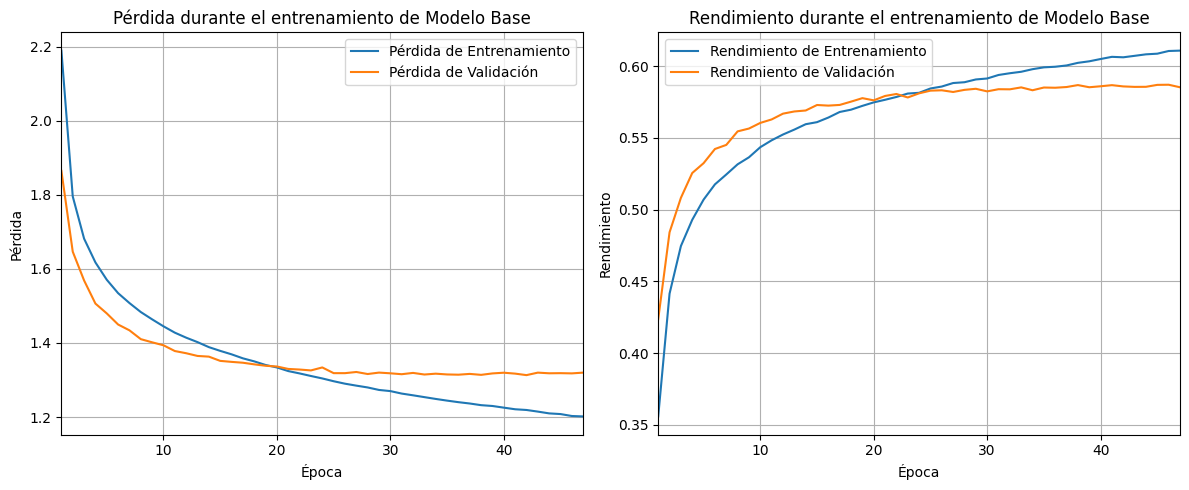

In [ ]:
if history_base is not None:
    print("Mostrando gráficos para el Modelo Base:")
    plot_training_history(history_base, model_name="Modelo Base")

La visualización muestra cómo evolucionan la pérdida y el rendimiento (precisión categórica) del Modelo Base a lo largo del proceso de entrenamiento y validación.

- En el gráfico de la izquierda, se aprecia una disminución sostenida de la pérdida en entrenamiento a lo largo de las épocas. La pérdida en validación también decrece rápidamente al principio y luego se estabiliza, lo cual sugiere que el modelo aprende patrones útiles sin evidencia clara de sobreajuste significativo.

- En el gráfico de la derecha, el rendimiento del modelo en entrenamiento mejora de manera constante, superando el 60% hacia el final del entrenamiento. En validación, el rendimiento también incrementa rápidamente durante las primeras épocas y luego se estabiliza, alcanzando un rendimiento cercano al observado en entrenamiento. Esta evolución indica que el modelo generaliza razonablemente bien a datos no vistos.

#### Métricas

Para evaluar el rendimiento más representativo del Modelo Base, se identificó la mejor época de entrenamiento según el valor mínimo de la pérdida en validación (val_loss)

In [ ]:
# Encontrar la época con la menor pérdida de validación
if 'val_loss' in history_base.history:
    best_epoch_index_base = np.argmin(history_base.history['val_loss'])
    best_epoch_base = best_epoch_index_base + 1 # Las épocas se indexan desde 1

    print(f"Mejor época para Modelo Base (basada en val_loss): {best_epoch_base}")

    # Obtener las métricas de la mejor época
    metrics_best_epoch_base = {
        'Modelo': 'Modelo Base (Mejor Época)',
        'Loss Entrenamiento': history_base.history['loss'][best_epoch_index_base],
        'Loss Validación': history_base.history['val_loss'][best_epoch_index_base],
        'Accuracy Entrenamiento': history_base.history['categorical_accuracy'][best_epoch_index_base],
        'Accuracy Validación': history_base.history['val_categorical_accuracy'][best_epoch_index_base]
    }
    display(pd.DataFrame([metrics_best_epoch_base]))
else:
    print("El historial del Modelo Base no contiene métricas de validación.")


Mejor época para Modelo Base (basada en val_loss): 42


,Modelo,Loss Entrenamiento,Loss Validación,Accuracy Entrenamiento,Accuracy Validación
0,Modelo Base (Mejor Época),1.219117,1.313231,0.606112,0.585825


 La mejor época correspondió a la época 42, lo cual indica que en ese punto el modelo alcanzó su mejor capacidad de generalización antes de que aparecieran posibles signos de sobreajuste.

En dicha época, la pérdida en entrenamiento fue de 1.219, mientras que la pérdida en validación alcanzó un valor ligeramente superior de 1.313. Esta diferencia es esperada y razonable, sugiriendo que el modelo logra un buen ajuste sin memorizar los datos. En cuanto a la precisión categórica, se obtuvo un 60.6 % en entrenamiento y 58.6 % en validación, lo cual refleja una performance equilibrada y consistente entre ambos conjuntos.

### 3.4. Generación de Texto

Luego, se utiliza el modelo entrenado para generar nuevo texto. Se parte de una secuencia inicial de caracteres (la "semilla") y, de forma iterativa, el modelo predice el siguiente carácter. Durante este proceso de generación, se explora cómo el parámetro de "temperatura" influye en la diversidad y aleatoriedad del texto producido.

In [ ]:
# Generación de texto
if modelo_base is not None:
    print("Generando texto con el modelo entrenado:")

    # Seleccionar una secuencia inicial al azar
    if 'texto' in globals() and len(texto) >= SEQ_LENGTH:
        if len(texto) - SEQ_LENGTH - 1 >= 0:
            start_pos = random.randint(0, len(texto) - SEQ_LENGTH - 1)
            seed_text = texto[start_pos:start_pos + SEQ_LENGTH]

            for temperature in TEMPERATURES_TO_TRY:
                print("\n------> Generando texto con temperature {}".format(temperature))
                generated_text = generate_text(seed_text, modelo_base, GENERATED_TEXT_LENGTH, temperature)
                print("Seed: {}".format(seed_text))
                print("Texto generado: {}".format(generated_text))
                print("-" * 50)
        else:
            print("No se pudo generar texto: la variable 'texto' es demasiado corta para obtener una secuencia de longitud SEQ_LENGTH.")

    else:
        print("No se pudo generar texto: la variable 'texto' no está disponible o es muy corta.")

else:
    print("El modelo no ha sido entrenado. Por favor, ejecuta la celda de entrenamiento primero.")

Generando texto con el modelo entrenado:

------> Generando texto con temperature 0.2
Seed: hado en no haber nacido en la 
Texto generado: hado en no haber nacido en la mano de la cabeza, y la cual dijo

-si no se viene a su señor don quijote de la mancha, y en el mundo de la mancha, y dijo

-si me parece -respondió don quijote-, porque se le había de ser en el casti
--------------------------------------------------

------> Generando texto con temperature 0.5
Seed: hado en no haber nacido en la 
Texto generado: hado en no haber nacido en la mesma misma intención sin compañal la señora dulcinea del toboso, y allí se lo han de ser acompañar la gracia de las entregas de su
manda y con su amo, que no podrá ver lo que me puede haber sino que 
--------------------------------------------------

------> Generando texto con temperature 1.0
Seed: hado en no haber nacido en la 
Texto generado: hado en no haber nacido en la alma
con la mano, y los preguntas casas. la
hraza le ya de escuchar y e

Al generar texto con el Modelo Base se observa que, con temperatura baja (0.2), el resultado es altamente coherente pero repetitivo, mostrando secuencias comunes aprendidas del corpus, como referencias reiteradas a “don Quijote de la Mancha”. Con una temperatura intermedia (0.5), el modelo comienza a introducir mayor variedad léxica, aunque aparecen ligeras inconsistencias y repeticiones. A temperatura 1.0, el texto se vuelve más diverso, pero pierde precisión gramatical y semántica, generando palabras parcialmente inventadas. Finalmente, con temperatura alta (1.2), el modelo produce frases caóticas y con bajo sentido, revelando un alto nivel de creatividad pero escasa coherencia. En conjunto, se confirma que la temperatura permite modular el equilibrio entre estabilidad y creatividad en la generación textual.

#### 3.4.1. Generación de Texto con Semilla Manual

Por último, se ilustra la capacidad del modelo para generar texto utilizando una semilla de texto específica proporcionada. Se muestra el resultado de aplicar el proceso de generación con esta semilla inicial y se observan los efectos de diferentes valores de temperatura en el texto generado.

In [ ]:
# Definir lista de temperaturas para usar con generate_text_from_seed
Temperaturas = [0.2, 0.5, 1.0, 1.2]

# Use modelo_base explicitly
if modelo_base is not None and \
   'SEQ_LENGTH' in globals() and 'NUM_CHARS' in globals() and \
   'char_to_indices' in globals() and 'indices_to_char' in globals() and \
   'generate_text_from_seed' in globals() and callable(generate_text_from_seed):

    seed_text_ejemplo = "el ingenioso don "
    longitud_generar = 200

    print(f"Texto semilla para la generación: '{seed_text_ejemplo}'")
    print(f"Longitud del texto a generar (adicional a la semilla): {longitud_generar}")
    print("Temperaturas a probar:", Temperaturas)

    # Itera sobre la lista de temperaturas
    for temperatura_actual in Temperaturas:
        print(f"\n--- Generando texto con Temperatura: {temperatura_actual} ---")

        texto_generado_ejemplo = generate_text_from_seed(
            modelo_base, # Pass modelo_base as the model
            seed_text_ejemplo,
            longitud_generar,
            temperature=temperatura_actual
        )

        print(f"Texto generado: {texto_generado_ejemplo}")
        print("-" * 50)

else:
    print("Error: Las variables/funciones necesarias para la generación manual de texto no están completamente definidas o el modelo base no ha sido entrenado.")
    print("Asegúrate de haber ejecutado todas las celdas anteriores, incluyendo la definición de generate_text_from_seed, sample, y el entrenamiento del modelo base.")

Texto semilla para la generación: 'el ingenioso don '
Longitud del texto a generar (adicional a la semilla): 200
Temperaturas a probar: [0.2, 0.5, 1.0, 1.2]

--- Generando texto con Temperatura: 0.2 ---
Texto generado: el ingenioso don quijote, que en la cual se le dijese a la mesma cabeza, que esta merced se le dieron la casa, y de la mancha, por el caballero, que está en el mundo.

-no se lo había de ser muy bien propósito, y a es
--------------------------------------------------

--- Generando texto con Temperatura: 0.5 ---
Texto generado: el ingenioso don quijote, y que el
agua con tantas palabras que en el mesmo hacerle de su amo venga mis desdichas de maestras de su padre tantas las aldencias, y aun te digo, porque se sola y había muy acidio a su cas
--------------------------------------------------

--- Generando texto con Temperatura: 1.0 ---
Texto generado: el ingenioso don quijote dejó el
dorotea; no más se capítila.

-pues cuarro -respondió sancho-, que
también roición que

Al generar texto a partir de la semilla manual "el ingenioso don", el modelo demuestra distintos comportamientos según la temperatura utilizada. Con temperatura baja (0.2), el texto es altamente estructurado y coherente, repitiendo fórmulas reconocibles del corpus como “don Quijote de la Mancha”, aunque con escasa variación. A 0.5, se mantiene el sentido general pero aparecen fragmentos más diversos, aunque con construcciones sintácticas poco naturales. Con temperatura 1.0, la generación se vuelve claramente más impredecible, introduciendo palabras inventadas y saltos temáticos que rompen la fluidez. Finalmente, con temperatura 1.2, el texto alcanza un nivel de creatividad extremo, resultando en frases caóticas y sin coherencia gramatical. Esta variación confirma el impacto directo de la temperatura sobre la diversidad y estabilidad del texto generado.

### 3.5. Creación del Modelo 2

Luego de definir y entrenar el Modelo Base, se introduce y evalúa un segundo modelo, denominado Modelo 2. Este modelo presenta una arquitectura similar pero con modificaciones respecto al anterior, con el objetivo de explorar si dichos cambios se traducen en un mejor rendimiento o en diferencias significativas en la calidad del texto generado.

Primero, se define la arquitectura del Modelo 2. Esta se compone de dos capas LSTM con 256 unidades cada una, seguidas de capas de normalización (BatchNormalization) y regularización (Dropout). A diferencia del Modelo Base, este modelo incluye recurrent_dropout=0.3 en la primera capa LSTM, lo que introduce una forma de regularización interna que afecta las conexiones temporales de la red, ayudando a reducir el sobreajuste.

La capa final es una capa Dense con activación softmax, que transforma la salida en una distribución de probabilidad sobre el conjunto completo de caracteres posibles. El modelo se compila utilizando la función de pérdida categorical_crossentropy y la métrica categorical_accuracy, que evalúa qué proporción de predicciones coinciden exactamente con el carácter correcto, siendo apropiada para tareas de clasificación multiclase con codificación one-hot.

In [ ]:
# Definir el modelo
modelo_2 = Sequential(name="Modelo_2")

# Primera capa LSTM
modelo_2.add(LSTM(256, input_shape=(SEQ_LENGTH, NUM_CHARS), return_sequences=True, recurrent_dropout=0.3, name="LSTM_1"))
modelo_2.add(BatchNormalization(name="BatchNorm_1"))
modelo_2.add(Dropout(0.3, name="Dropout_1"))

# Segunda capa LSTM
modelo_2.add(LSTM(256, return_sequences=False, name="LSTM_2"))
modelo_2.add(BatchNormalization(name="BatchNorm_2"))
modelo_2.add(Dropout(0.3, name="Dropout_2"))

# Capa de salida
modelo_2.add(Dense(NUM_CHARS, activation='softmax', name="Densa_salida"))

# Compilación
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelo_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

modelo_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Modelo_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 30, 256)        │       308,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1                     │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Densa_salida (Dense)            │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,892 (3.23 MB)

 Trainable params: 845,868 (3.23 MB)

 Non-trainable params: 1,024 (4.00 KB)

### 3.6. Entrenamiento del Modelo 2

Luego, se procede al entrenamiento del Modelo 2 utilizando los mismos conjuntos de datos de entrenamiento, validación y prueba que el Modelo Base. El entrenamiento se lleva a cabo aplicando el mismo proceso y utilizando los mismos hiperparámetros definidos para el Modelo Base, como el tamaño del Batchsize (128), el número de épocas (50) y el callback.

In [ ]:
checkpoint_callback_2 = ModelCheckpoint(
    filepath='best_model_2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

best_model_2, history_model_2, report_model_2 = train_and_test(
    modelo_2,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping_callback, checkpoint_callback_2]
)

Entrenando modelo: Modelo_2
Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.2764 - loss: 2.7142
Epoch 1: val_loss improved from inf to 1.79421, saving model to best_model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 55ms/step - categorical_accuracy: 0.2764 - loss: 2.7140 - val_categorical_accuracy: 0.4432 - val_loss: 1.7942
Epoch 2/50
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.4272 - loss: 1.8467
Epoch 2: val_loss improved from 1.79421 to 1.63119, saving model to best_model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 141s 55ms/step - categorical_accuracy: 0.4272 - loss: 1.8467 - val_categorical_accuracy: 0.4872 - val_loss: 1.6312
Epoch 3/50
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.4674 - loss: 1.7029
Epoch 3: val_loss improved from 1.63119 to 1.54829, saving model to best_model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 138s 55ms/step - categorical_accuracy: 0.4674 - loss: 1.7029 - val_categorical_accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 42, does not match size of target_names, 44
  warnings.warn(


#### Visualización

Mostrando gráficos para el Modelo 2:


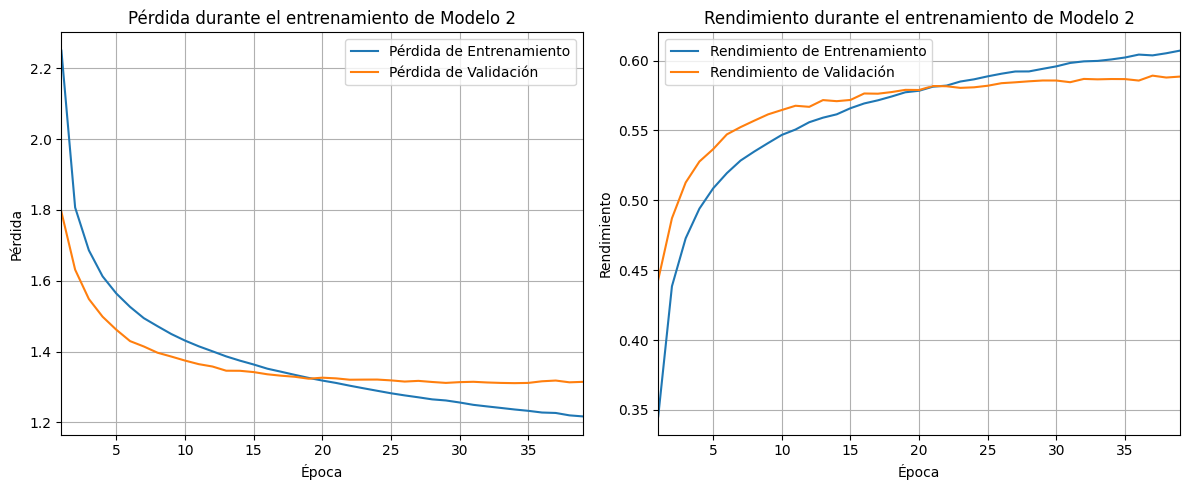

In [ ]:
if history_model_2 is not None:
    print("Mostrando gráficos para el Modelo 2:")
    plot_training_history(history_model_2, model_name="Modelo 2")

En los gráficos se observa la evolución de la pérdida y del rendimiento (precisión categórica) del Modelo 2 a lo largo del proceso de entrenamiento y validación. En la curva de pérdida, se aprecia una disminución progresiva y sostenida tanto en los datos de entrenamiento como de validación, con una diferencia moderada entre ambas curvas. Esto sugiere que el modelo logra un aprendizaje eficaz sin signos evidentes de sobreajuste.

En cuanto al rendimiento, el Modelo 2 alcanza una precisión categórica superior al 60 % en entrenamiento y cercana al 59 % en validación, lo que indica una mejora respecto al Modelo Base. Además, la cercanía entre ambas curvas sugiere una buena capacidad de generalización. El hecho de que la curva de validación se estabilice a partir de cierta época refuerza la idea de que el modelo se beneficia de la arquitectura más profunda y de las técnicas de regularización introducidas.

#### Métricas

Para identificar el punto de mejor rendimiento del Modelo 2, se analizó la época con la menor pérdida en validación (val_loss).

In [ ]:

if 'val_loss' in history_model_2.history:
    best_epoch_index_model_2 = np.argmin(history_model_2.history['val_loss'])
    best_epoch_model_2 = best_epoch_index_model_2 + 1 # Las épocas se indexan desde 1

    print(f"\nMejor época para Modelo 2 (basada en val_loss): {best_epoch_model_2}")

    # Obtener las métricas de la mejor época
    metrics_best_epoch_model_2 = {
        'Modelo': 'Modelo 2 (Mejor Época)',
        'Loss Entrenamiento': history_model_2.history['loss'][best_epoch_index_model_2],
        'Loss Validación': history_model_2.history['val_loss'][best_epoch_index_model_2],
        'Accuracy Entrenamiento': history_model_2.history['categorical_accuracy'][best_epoch_index_model_2],
        'Accuracy Validación': history_model_2.history['val_categorical_accuracy'][best_epoch_index_model_2]
    }
    display(pd.DataFrame([metrics_best_epoch_model_2]))
else:
    print("\nEl historial del Modelo 2 no contiene métricas de validación.")


Mejor época para Modelo 2 (basada en val_loss): 34


,Modelo,Loss Entrenamiento,Loss Validación,Accuracy Entrenamiento,Accuracy Validación
0,Modelo 2 (Mejor Época),1.236407,1.31075,0.600856,0.586825


La mejor época identificada en el entrenamiento correspondió a la época 34, donde el modelo logró su mayor capacidad de generalización antes de estabilizarse o incurrir en sobreajuste.

En esa época, la pérdida en entrenamiento fue de 1.236, mientras que la pérdida en validación alcanzó un valor de 1.311, prácticamente idéntica a la obtenida por el Modelo Base en su mejor punto. La precisión categórica fue de 60.1 % en entrenamiento y 58.7 % en validación, también muy similar a los valores obtenidos previamente.

### 3.7. Generación de Texto

Luego, se utiliza el modelo entrenado para generar nuevo texto. Se parte de una secuencia inicial de caracteres (la "semilla") y, de forma iterativa, el modelo predice el siguiente carácter. Durante este proceso de generación, se explora cómo el parámetro de "temperatura" influye en la diversidad y aleatoriedad del texto producido.

In [ ]:
# Generación de texto
if modelo_2 is not None:
    print("Generando texto con el modelo entrenado:")

    # Seleccionar una secuencia inicial al azar
    if 'texto' in globals() and len(texto) >= SEQ_LENGTH:
        if len(texto) - SEQ_LENGTH - 1 >= 0:
            start_pos = random.randint(0, len(texto) - SEQ_LENGTH - 1)
            seed_text = texto[start_pos:start_pos + SEQ_LENGTH]

            for temperature in TEMPERATURES_TO_TRY:
                print("\n------> Generando texto con temperature {}".format(temperature))
                generated_text = generate_text(seed_text, modelo_2, GENERATED_TEXT_LENGTH, temperature)
                print("Seed: {}".format(seed_text))
                print("Texto generado: {}".format(generated_text))
                print("-" * 50)
        else:
            print("No se pudo generar texto: la variable 'texto' es demasiado corta para obtener una secuencia de longitud SEQ_LENGTH.")

    else:
        print("No se pudo generar texto: la variable 'texto' no está disponible o es muy corta.")

else:
    print("El modelo no ha sido entrenado. Por favor, ejecuta la celda de entrenamiento primero.")

Generando texto con el modelo entrenado:

------> Generando texto con temperature 0.2
Seed:  gusto de ver que acerté en mi
Texto generado:  gusto de ver que acerté en mi padre de la mano, y que el cual se había de hacer la cabeza de la mano de su amo.

-así es -respondió don quijote-, porque es el todo lo que de aquella cabeza la cabeza de la mano, y que el de los de
--------------------------------------------------

------> Generando texto con temperature 0.5
Seed:  gusto de ver que acerté en mi
Texto generado:  gusto de ver que acerté en mi señor la alcanza, a la duquesa y
acabó de condenir a la señora dulcinea del toboso, y lo que le tendría ver la contra a aquel
como el autor de pensamiento a ella, y que el suelo de la mano de la donc
--------------------------------------------------

------> Generando texto con temperature 1.0
Seed:  gusto de ver que acerté en mi
Texto generado:  gusto de ver que acerté en mi furiente y le dijo
   -dijo, en tanto que yo os esperaba mucho jure qu

Al generar texto con el Modelo 2 se observa un comportamiento consistente con lo esperado respecto al control de temperatura. Con temperatura baja (0.2), el modelo genera frases coherentes pero altamente repetitivas, centradas en estructuras comunes como “la cabeza de la mano” o “respondió don Quijote”, reflejando una fuerte adhesión a patrones frecuentes del corpus. Al incrementar la temperatura a 0.5, el texto gana en variación y fluidez, aunque aún mantiene una estructura sintáctica reconocible y un contexto narrativo lógico. A temperatura 1.0, se evidencia una mayor diversidad y creatividad, aunque ya comienzan a aparecer construcciones confusas o términos poco claros. Con temperatura 1.2, la generación se torna mucho más caótica, con frases desordenadas, palabras poco comprensibles y una pérdida notable de coherencia. En conjunto, se confirma que el Modelo 2 responde de manera similar al modelo base frente a los ajustes de temperatura, permitiendo modular la creatividad en función del grado de aleatoriedad deseado.

#### 3.7.1. Generación de Texto con Semilla Manual

In [ ]:
# Definir lista de temperaturas para usar con generate_text_from_seed
Temperaturas = [0.2, 0.5, 1.0, 1.2]

# Use modelo_base explicitly
if modelo_2 is not None and \
   'SEQ_LENGTH' in globals() and 'NUM_CHARS' in globals() and \
   'char_to_indices' in globals() and 'indices_to_char' in globals() and \
   'generate_text_from_seed' in globals() and callable(generate_text_from_seed):

    seed_text_ejemplo = "el ingenioso don "
    longitud_generar = 200

    print(f"Texto semilla para la generación: '{seed_text_ejemplo}'")
    print(f"Longitud del texto a generar (adicional a la semilla): {longitud_generar}")
    print("Temperaturas a probar:", Temperaturas)

    # Itera sobre la lista de temperaturas
    for temperatura_actual in Temperaturas:
        print(f"\n--- Generando texto con Temperatura: {temperatura_actual} ---")

        texto_generado_ejemplo = generate_text_from_seed(
            modelo_2, # Pass modelo_base as the model
            seed_text_ejemplo,
            longitud_generar,
            temperature=temperatura_actual
        )

        print(f"Texto generado: {texto_generado_ejemplo}")
        print("-" * 50)

else:
    print("Error: Las variables/funciones necesarias para la generación manual de texto no están completamente definidas o el modelo base no ha sido entrenado.")
    print("Asegúrate de haber ejecutado todas las celdas anteriores, incluyendo la definición de generate_text_from_seed, sample, y el entrenamiento del modelo base.")

Texto semilla para la generación: 'el ingenioso don '
Longitud del texto a generar (adicional a la semilla): 200
Temperaturas a probar: [0.2, 0.5, 1.0, 1.2]

--- Generando texto con Temperatura: 0.2 ---
Texto generado: el ingenioso don quijote de la mancha, a lo que le dijo

-si es que es escudero de la mano de la concena a la cabeza de la mano de la mano de la mano de la grande ama de la mano que le dijese que le persona a la cabez
--------------------------------------------------

--- Generando texto con Temperatura: 0.5 ---
Texto generado: el ingenioso don quijote de la cabeza, y de
por mi reposentado y de ver a ser pensade y almohado a los caballeros andantes había salido de mano, con mucha ventura de los agravios que le diese para saber que los
pocos 
--------------------------------------------------

--- Generando texto con Temperatura: 1.0 ---
Texto generado: el ingenioso don quijote
había acometer, por vejos otra lesa
convienen. la caésta, señoría que no tan podía
ser vida, y

Al generar texto con el Modelo 2 a partir de una semilla manual ("el ingenioso don"), se observa nuevamente cómo la temperatura influye directamente en la diversidad y coherencia del texto generado. Con temperatura 0.2, el modelo produce frases altamente repetitivas y previsibles, centradas en estructuras comunes como “la mano de la cabeza”, lo que indica una fuerte adhesión a los patrones más frecuentes del corpus. Con temperatura 0.5, se mantiene cierta coherencia, pero ya aparecen combinaciones de palabras más variadas y una mayor fluidez narrativa, aunque con leves errores sintácticos.

A temperatura 1.0, la generación se vuelve considerablemente más creativa y arriesgada, introduciendo neologismos o palabras deformadas, y mostrando frases con menor cohesión semántica. Finalmente, a temperatura 1.2, el texto pierde casi por completo la coherencia, generando expresiones caóticas y sin sentido claro, reflejando un alto grado de aleatoriedad. Esta progresión reafirma que la temperatura actúa como un regulador del balance entre estabilidad y creatividad, incluso cuando se parte de una semilla

## 4. Comparación de Modelos Entrenados



Comparando historiales de entrenamiento (Pérdida y Precisión)...


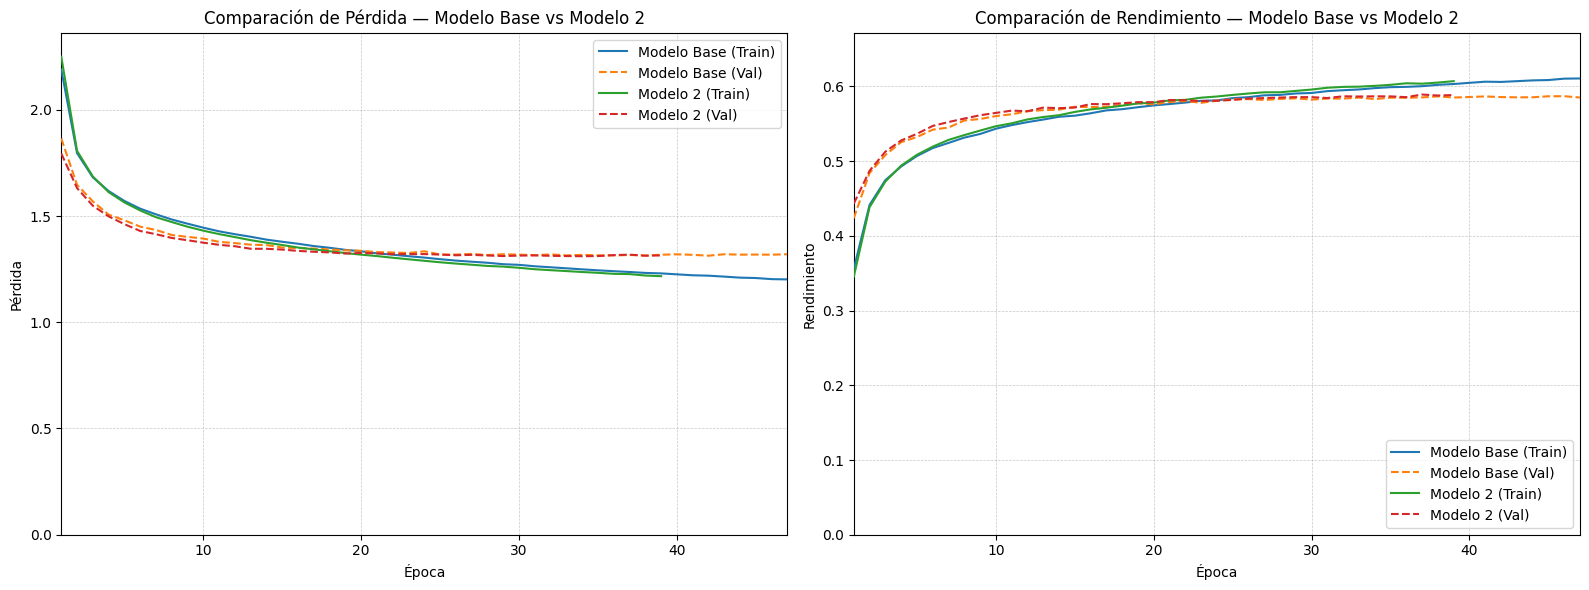

In [ ]:
print("Comparando historiales de entrenamiento (Pérdida y Precisión)...")
comparar_modelos(history_base, history_model_2,
                 nombre_base='Modelo Base',
                 nombre_mod='Modelo 2')

En la comparación visual entre el Modelo Base y el Modelo 2, se observan diferencias sutiles pero relevantes en cuanto a pérdida y rendimiento a lo largo de las épocas.

En el gráfico de pérdida (izquierda), ambos modelos muestran una tendencia decreciente tanto en entrenamiento como en validación, indicando un aprendizaje progresivo. Sin embargo, el Modelo 2 logra estabilizar antes su pérdida de validación, mostrando una curva ligeramente más plana y constante a partir de la época 20, mientras que el Modelo Base presenta más variabilidad, lo cual podría indicar una mayor propensión al sobreajuste.

En cuanto al rendimiento (gráfico derecho), ambos modelos alcanzan niveles similares de precisión categórica, pero el Modelo 2 presenta una leve ventaja en las primeras épocas, especialmente en validación. Hacia el final del entrenamiento, el rendimiento de ambos se aproxima, aunque el Modelo 2 logra un ascenso más continuo y sostenido en la curva de entrenamiento.

In [ ]:
# Extraer las métricas de los objetos history para la mejor época
metrics_base = {
    'Modelo': 'Modelo Base (Mejor Época)',
    'Loss Entrenamiento': history_base.history['loss'][best_epoch_index_base],
    'Loss Validación': history_base.history['val_loss'][best_epoch_index_base] if 'val_loss' in history_base.history else 'N/A',
    'Accuracy Entrenamiento': history_base.history['categorical_accuracy'][best_epoch_index_base],
    'Accuracy Validación': history_base.history['val_categorical_accuracy'][best_epoch_index_base] if 'val_categorical_accuracy' in history_base.history else 'N/A'
}

metrics_model_2 = {
    'Modelo': 'Modelo 2 (Mejor Época)',
    'Loss Entrenamiento': history_model_2.history['loss'][best_epoch_index_model_2],
    'Loss Validación': history_model_2.history['val_loss'][best_epoch_index_model_2] if 'val_loss' in history_model_2.history else 'N/A',
    'Accuracy Entrenamiento': history_model_2.history['categorical_accuracy'][best_epoch_index_model_2],
    'Accuracy Validación': history_model_2.history['val_categorical_accuracy'][best_epoch_index_model_2] if 'val_categorical_accuracy' in history_model_2.history else 'N/A'
}

# Crear un DataFrame para mostrar las métricas
df_metrics_comparison = pd.DataFrame([metrics_base, metrics_model_2])

# Mostrar el DataFrame
display(df_metrics_comparison)

,Modelo,Loss Entrenamiento,Loss Validación,Accuracy Entrenamiento,Accuracy Validación
0,Modelo Base (Mejor Época),1.219117,1.313231,0.606112,0.585825
1,Modelo 2 (Mejor Época),1.236407,1.310750,0.600856,0.586825


Al comparar las métricas obtenidas en la mejor época de cada modelo, se evidencia que ambos alcanzan un rendimiento muy similar tanto en pérdida como en precisión categórica. El Modelo Base logró una menor pérdida en entrenamiento (1.219) y una validación de 1.313, mientras que el Modelo 2 presentó una ligera pérdida adicional en entrenamiento (1.236) pero una validación marginalmente mejor (1.310).

Respecto a la precisión categórica, el Modelo Base obtuvo 60.6 % en entrenamiento y 58.6 % en validación, frente al 60.1 % y 58.7 % respectivamente del Modelo 2. Esta diferencia es mínima pero favorable al Modelo 2, lo que refuerza la percepción obtenida en las curvas de entrenamiento: una arquitectura más regularizada puede facilitar una mejor generalización sin sacrificar capacidad de aprendizaje.

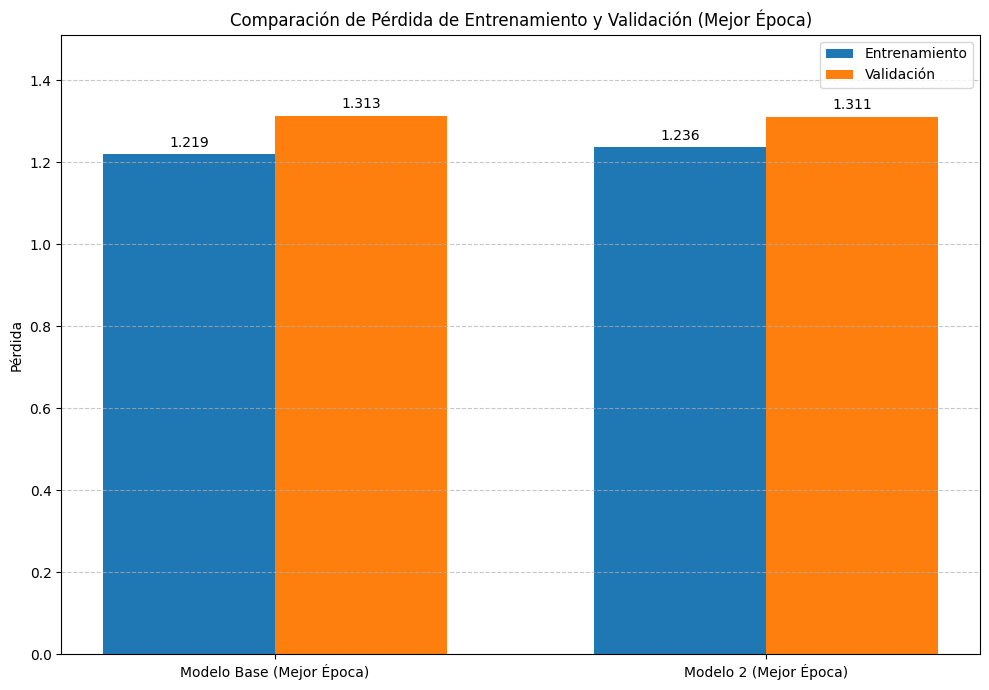

In [ ]:
# Extraer los nombres de los modelos y las métricas finales del DataFrame
models = df_metrics_comparison['Modelo']
train_loss = df_metrics_comparison['Loss Entrenamiento']
val_loss = df_metrics_comparison['Loss Validación']


x = np.arange(len(models)) # las posiciones de las etiquetas en x
width = 0.35 # el ancho de las barras

fig, ax = plt.subplots(1, 1, figsize=(10, 7)) # Aumentar el tamaño de la figura

# Gráfico de Pérdida
rects1 = ax.bar(x - width/2, train_loss, width, label='Entrenamiento')
rects2 = ax.bar(x + width/2, val_loss, width, label='Validación')

# Añadir etiquetas numéricas en las barras
def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


ax.set_ylabel('Pérdida')
ax.set_title('Comparación de Pérdida de Entrenamiento y Validación (Mejor Época)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper right') # Mantener la posición de la leyenda
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar los límites del eje y para dar espacio a las etiquetas
ax.set_ylim(0, max(train_loss.max(), val_loss.max()) * 1.15) # Aumentar el límite superior del eje y

plt.tight_layout()
plt.show()

El gráfico de barras ilustra comparativamente la pérdida de entrenamiento y validación para ambos modelos en su mejor época, lo que permite una evaluación directa de su desempeño.

Se observa que el Modelo Base logró una menor pérdida en entrenamiento (1.219) que el Modelo 2 (1.236), lo cual podría indicar que se ajustó ligeramente mejor a los datos de entrenamiento. Sin embargo, cuando se analiza la pérdida en validación, el Modelo 2 presenta una ventaja leve, con un valor de 1.311 frente a 1.313 del Modelo Base.

Esta diferencia, aunque pequeña, sugiere que el Modelo 2 logra una mejor generalización, posiblemente gracias a las técnicas de regularización incorporadas (como recurrent_dropout). Además, la cercanía entre ambas pérdidas en cada modelo indica que no hay evidencia fuerte de sobreajuste, ya que el gap entre entrenamiento y validación es moderado y consistente.

## Conclusiones Finales

A lo largo de este trabajo se implementaron y compararon dos modelos basados en redes LSTM para la generación de texto carácter a carácter, utilizando como corpus fragmentos de *Don Quijote de la Mancha*. Ambos modelos fueron entrenados con representación one-hot y evaluados en términos de pérdida y exactitud tanto en entrenamiento como validación.

Se observó que ambos modelos lograron aprender patrones léxicos y estructurales del corpus, siendo capaces de generar secuencias de texto en español con palabras reconocibles, e incluso con estilo narrativo similar al original. La modulación de la **temperatura** durante la generación permitió ajustar el grado de creatividad del modelo: temperaturas bajas generaron texto más repetitivo pero coherente, mientras que temperaturas altas dieron lugar a secuencias más creativas, aunque con menor coherencia semántica.

Al comparar el **Modelo Base** con el **Modelo 2** (que introdujo `recurrent_dropout`), se apreció un rendimiento muy similar. Sin embargo, el Modelo 2 mostró una **ligera ventaja en pérdida de validación**, lo cual podría indicar una mejor capacidad de generalización, aunque la diferencia fue marginal.

Durante la experimentación también se intentaron **ajustes en la longitud de secuencia (`SEQ_LENGTH`)**, incrementándola de 30 a 35 caracteres. Si bien esto buscaba capturar dependencias a mayor plazo, se evidenció una **limitación crítica en los recursos de RAM disponibles**, lo que imposibilitó seguir con esta configuración. De manera similar, al aumentar el parámetro `max_sequences` durante la generación del dataset, también se produjo un agotamiento de memoria. Estos desafíos revelan la necesidad de equilibrar la complejidad del modelo y el volumen de datos con las capacidades computacionales del entorno.

Finalmente, el trabajo cumple con los objetivos planteados, permitiendo explorar la generación de texto en español desde un enfoque práctico, interpretar la evolución de aprendizaje a lo largo de las épocas y comprender el impacto de distintos factores como la arquitectura, temperatura y longitud de secuencia en el comportamiento de los modelos de lenguaje.
